# 4. Quantum Binary classifier using Keras

###   Nikolaos Schetakis , nsxetakis@yahoo.gr

In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
from numpy import loadtxt
#n_qubits = X_train.shape[1] # Number of qubits equals number of features, max number = 25
n_qubits = 2
LABELplot=""
blocks = 6 #number of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 1  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )
dropoutrate = 0

#epochsC = 50 #800 # Classical pre-training epochs. Used for hot-starting the classical part of the hybrid
epochsH = 30 # Hybrid training epochs

batch_size = 16 #100
np.random.seed(42)
learning_rate = 0.02 #0.001 #0.2 # Learning ratefor optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999) #tf.keras.optimizers.SGD(learning_rate=learning_rate) #Select optimizer

dev = qml.device("default.qubit.tf", wires=n_qubits) # Run the model in classical CPU
qml.enable_tape() #enable tape mode. Tape mode must be disabled to run in a QPU




X_train = loadtxt('X_train_ST2_N06.csv', delimiter=',')
y_train = loadtxt('y_train_ST2_N06.csv', delimiter=',')
X_val = loadtxt('X_val_ST2_N06.csv', delimiter=',')
y_val = loadtxt('y_val_ST2_N06.csv', delimiter=',')
X_test = loadtxt('X_test_ST2_N06.csv', delimiter=',')
y_test = loadtxt('y_test_ST2_N06.csv', delimiter=',')
#----------- un-comment to run model in IMB's QPU -----------
#import qiskit
#from qiskit import IBMQ
#IBMQ.save_account('f91e7d2f1d7e7f00d905000fd611ec9dcbeca2aca096cec8632fbdf6f07dec9eda1560542db96f42e9e6bfb857cc73e37966f622c35e9fbaae931d5a93787fbe',overwrite=True)
#dev = qml.device('qiskit.ibmq', wires=n_qubits, backend='ibmq_qasm_simulator')
#qml.disable_tape()
#----------------------------------------------------

###  Plotting functions: 
### AUCROC functions

In [2]:
#Plotting function
from matplotlib import pyplot as plt

       
def AUC_roc_plot():    
    from sklearn.metrics import roc_curve , auc
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test')
    plt.legend(loc="lower right")
    plt.show()
    auc_score=roc_auc_score(y_test,y_pred) 
    
    
def AUC_roc_plot1():    
    from sklearn.metrics import roc_curve , auc
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_val, y_pred1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred1.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Validation')
    plt.legend(loc="lower right")
    plt.show()
    auc_score=roc_auc_score(y_val,y_pred1)     

## 4.2 Build Hybrid model:

### 4.2.1 Build quantum node:

In [3]:
# Define quantum node
@qml.qnode(dev, interface="tf", grad_method="backprop")
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
#       qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) #BASIC ENTANGLER LAYERS , chan
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits)) #STRONGLY ENTANGLING LAYERS
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Set initial random weights to qnode depending on whether you have used
# Basic entangler layers or Strongly entangling layers.
#The weights argument of the QNode is trainable 
#weight_shapes = {"weights": (layers, n_qubits)} # Uncomment for Basic entangler layers
weights_shape = (blocks, layers, n_qubits, 3) # Uncomment for Strongly entangling layers


###weights = tf.Variable(np.random.random(weights_shape))
###inputs = tf.constant(np.random.random(n_qubits))
#print("Output of QNode:", qnode(inputs, weights).numpy())

### 4.2.2 Load Classical model:

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from os import path

#modelC = load_model("best_model_Classical.h5")
#y_pred = modelC.predict_classes(X_test)
#from sklearn.metrics import classification_report, confusion_matrix
#confusion_matrix(y_test, y_pred)
#y_pred = modelC.predict_proba(X_test)
#y_pred1 = modelC.predict_proba(X_val)
#AUC_roc_plot()
#AUC_roc_plot1()

## 4.2.3 Plotting AUCROC for classical model only

### 4.2.4 Freeze weights for Transfer Learning:

In [5]:
## Set to FALSE for transfer learning
#clayerM.trainable = False
#clayerF.trainable = False
#clayerF.trainable = False



#modelC.trainable = True
#for layer in modelC.layers: layer.trainable = True

In [6]:
#get model weights
#modelc.layers[0].get_weights()

## 4.3 Training the Hybrid model:

In [7]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint


# Define custom activation function for final classical layer

#If custom activation function Csigmoid is used 
#then modelcheckpoint produces error and cannot save the best model as best_model.h5
from tensorflow.keras import backend as K

def Csigmoid(x):
    return (K.sigmoid(x) * 3.14) 

# Optionally convert to Keras layer:
tf.keras.backend.set_floatx("float64")
weight_shapes = {"weights": weights_shape}

#X_train.shape[1]
# Create the Hybrid model
#------------ classical Master layer ------------
clayerM = tf.keras.layers.Dense(X_train.shape[1], activation="relu") 
#------------ Classical feeding layer. Must have same dimensions as qnode's qubits ------------
clayerF = tf.keras.layers.LeakyReLU(alpha=0.3) #tf.keras.layers.Dense(n_qubits, activation="leaky_relu")#Csigmoid)
clayerF1 = tf.keras.layers.Dense(n_qubits, activation="relu")
#dropout layer
clayerDropout = tf.keras.layers.Dropout(dropoutrate)
#------------ Quantum layer. It consists of the quantum node as defined before ------------
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits)
#------------ Classical Decision layer ------------
clayerD = tf.keras.layers.Dense(1, activation="sigmoid")

inputs = tf.constant(np.random.random((batch_size, n_qubits)))
#print("Output of quantum layer:\n", qlayer(inputs).numpy())




# Include classical and quantum layers 
modelh = tf.keras.models.Sequential([qlayer,clayerM,clayerF,clayerDropout,clayerD])
#modelh = tf.keras.Sequential([saved_model,qlayer,clayerD])

es = EarlyStopping(monitor='auc', min_delta=1e-9, patience=600, verbose=1) #'sparse_categorical_accuracy'

mc = ModelCheckpoint('best_model_Classical.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True) #'sparse_categorical_accuracy'

rp = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, 
                                  patience = 15, min_delta = 0.001, 
                                  mode = 'min', verbose = 1)


modelh.compile(opt, loss='binary_crossentropy',
               metrics=[AUC(name = 'auc')])#'sparse_categorical_accuracy','categorical_accuracy','binary_accuracy', 'accuracy'])

modelh.build(input_shape=X_train.shape)

historyh = modelh.fit(X_train, y_train,
                      #validation_split = 0.1,    
                      validation_data=(X_val, y_val),
                      callbacks=[es,rp],
                      epochs=epochsH,
                      batch_size=batch_size,
                     shuffle=True)

modelh.summary()

Epoch 1/30
63/63 [==============================] - 70s 1s/step - loss: 0.6369 - auc: 0.7185 - val_loss: 0.5554 - val_auc: 0.7735
Epoch 2/30
63/63 [==============================] - 73s 1s/step - loss: 0.5347 - auc: 0.7476 - val_loss: 0.5199 - val_auc: 0.7537
Epoch 3/30
63/63 [==============================] - 73s 1s/step - loss: 0.5222 - auc: 0.7593 - val_loss: 0.5236 - val_auc: 0.7679
Epoch 4/30
63/63 [==============================] - 75s 1s/step - loss: 0.5057 - auc: 0.7771 - val_loss: 0.5206 - val_auc: 0.7684
Epoch 5/30
63/63 [==============================] - 74s 1s/step - loss: 0.4949 - auc: 0.7737 - val_loss: 0.5208 - val_auc: 0.7580
Epoch 6/30
63/63 [==============================] - 70s 1s/step - loss: 0.5135 - auc: 0.7730 - val_loss: 0.5256 - val_auc: 0.7641
Epoch 7/30
63/63 [==============================] - 70s 1s/step - loss: 0.5000 - auc: 0.7675 - val_loss: 0.5152 - val_auc: 0.7604
Epoch 8/30
63/63 [==============================] - 70s 1s/step - loss: 0.5059 - auc: 0.76

In [8]:
# Make predictions 
y_pred = modelh.predict_proba(X_test)
y_pred1 = modelh.predict_proba(X_val)

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


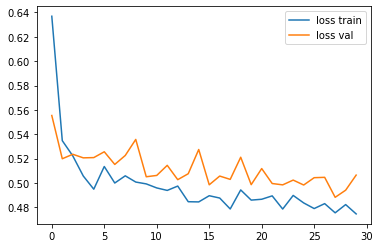

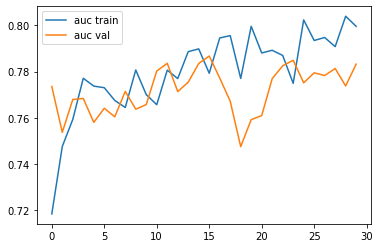

In [9]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss val')
pyplot.legend()
pyplot.show()

#pyplot.plot(historyh.history['binary_accuracy'], label='accuracy train')
#pyplot.plot(historyh.history['val_binary_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
#pyplot.legend()
#pyplot.show()

pyplot.plot(historyh.history['auc'], label='auc train')
pyplot.plot(historyh.history['val_auc'], label='auc val')
pyplot.legend()
pyplot.show()

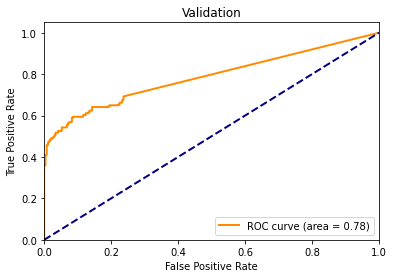

In [10]:
AUC_roc_plot1()

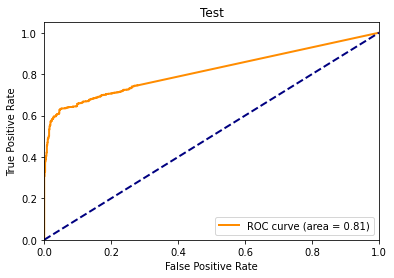

In [11]:
AUC_roc_plot() 

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, average=None)

0.8139774680839338

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred1, average=None)

0.7848627980206928

In [14]:
#modelh.layers[0].get_weights()

In [15]:
x = X_test[:,0]
y = X_test[:,1]

z = y_test

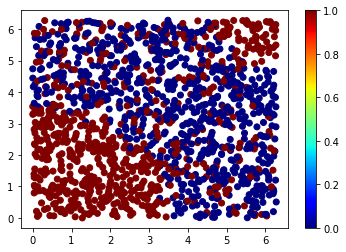

In [16]:
#Real dataset
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(x, y, c=z,cmap='jet', marker='o')
plt.colorbar()
plt.show()

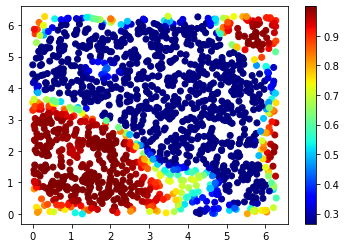

In [17]:
#Predictions dataset
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(x, y, c=y_pred,cmap='jet', marker='o')
plt.colorbar()
plt.show()

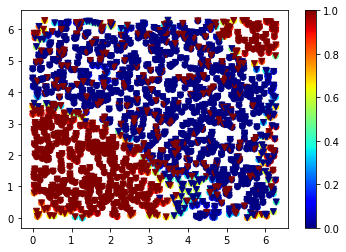

In [18]:
#Real and Predictions dataset
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(x, y, c=y_pred,cmap='jet', marker='o')
plt.scatter(x, y, c=z,cmap='jet', marker='v')
plt.colorbar()
plt.show()


In [19]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0, 0.5, '')

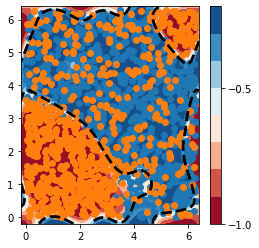

In [20]:
from numpy import arange, meshgrid, hstack
# define bounds of the domain
plt.figure(figsize=(4,4))
min1, max1 = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
min2, max2 = X_test[:, 1].min()-0.2, X_test[:, 1].max()+0.2
# define the x and y scale
x1grid = arange(min1, max1, 0.1)
x2grid = arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = hstack((r1,r2))
# make predictions for the grid
yhat = -modelh.predict(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface
pyplot.contourf(xx, yy, zz, cmap='RdBu')
c = pyplot.contourf(xx, yy, zz, cmap = 'RdBu')
plt.colorbar(c,ticks=[0.,-0.5,-1])
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_test == class_value)
    # create scatter of these samples
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], cmap = 'RdBu')
plt.contour(xx, yy,zz, levels=[-0.5], colors=("black",), linestyles=("--",), linewidths=(2.8,))
plt.title(label=LABELplot,
          fontsize=12,
          color="Black")
plt.xlabel('')
plt.ylabel('')
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='Paired')
#plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val,cmap='Paired')
#plt.show()

In [21]:
y_pred = modelh.predict_classes(X_test)
#y_pred1 = modelh.predict_classes(X_val)

from numpy import arange, meshgrid, hstack
plt.figure()
cm = plt.cm.RdBu_r
fig= plt.figure(figsize=(15,15))
# make data for decision regions
# define bounds of the domain
min1, max1 = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
min2, max2 = X_test[:, 1].min()-0.2, X_test[:, 1].max()+0.2
# define the x and y scale
x1grid = arange(min1, max1, 0.1)
x2grid = arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = hstack((r1,r2))
# make predictions for the grid
yhat = modelh.predict_classes(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 432x288 with 0 Axes>

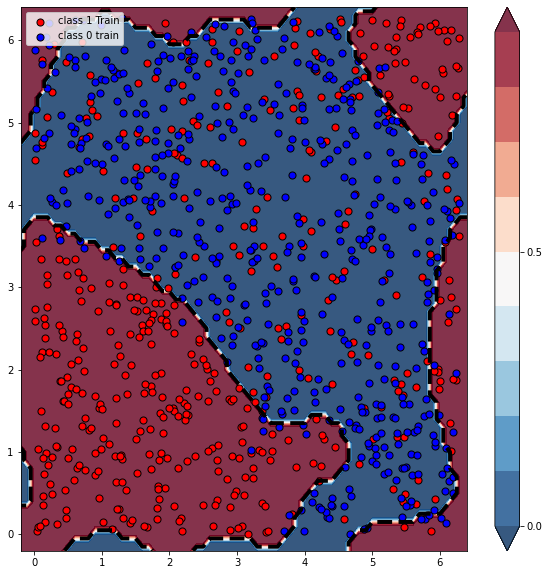

In [22]:
from numpy import arange, meshgrid, hstack
plt.figure()
fig= plt.figure(figsize=(10,10))
cm = plt.cm.RdBu_r
# plot decision regions
cnt = plt.contourf(xx, yy,zz, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(4.0,))
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(
    X_train[:, 0][y_train == 1],
    X_train[:, 1][y_train == 1],
    c="r",s=50,
    marker="o",
    edgecolors="k",
    label="class 1 Train",
)
plt.scatter(
       X_train[:, 0][y_train == 0],
       X_train[:, 1][y_train == 0],
    c="b",
    marker="o",s=50,
    edgecolors="k",
    label="class 0 train",
)

plt.title(label=LABELplot,
          fontsize=12,
          color="Black")
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper left')
plt.show()

In [23]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[645, 108],
       [238, 509]], dtype=int64)

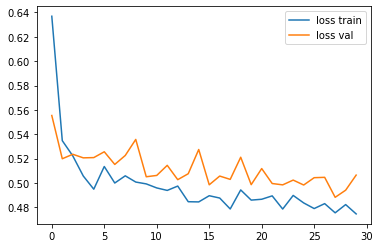

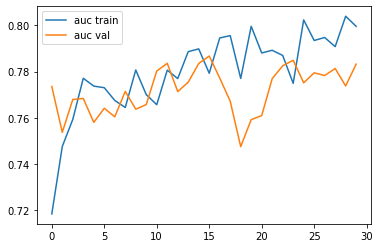

In [24]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss val')
pyplot.legend()
pyplot.show()

#pyplot.plot(historyh.history['binary_accuracy'], label='accuracy train')
#pyplot.plot(historyh.history['val_binary_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
#pyplot.legend()
#pyplot.show()

pyplot.plot(historyh.history['auc'], label='auc train')
pyplot.plot(historyh.history['val_auc'], label='auc val')
pyplot.legend()
pyplot.show()

<Figure size 432x288 with 0 Axes>

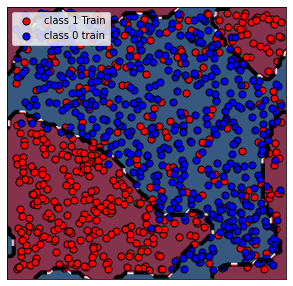

In [25]:
from numpy import arange, meshgrid, hstack
plt.figure()
fig= plt.figure(figsize=(5,5))
cm = plt.cm.RdBu_r
# plot decision regions
cnt = plt.contourf(xx, yy,zz, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(4.0,))


# plot data
plt.scatter(
    X_train[:, 0][y_train == 1],
    X_train[:, 1][y_train == 1],
    c="r",s=50,
    marker="o",
    edgecolors="k",
    label="class 1 Train",
)
plt.scatter(
       X_train[:, 0][y_train == 0],
       X_train[:, 1][y_train == 0],
    c="b",
    marker="o",s=50,
    edgecolors="k",
    label="class 0 train",
)

plt.title(label=LABELplot,
          fontsize=12,
          color="Black")
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper left',fontsize=10)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

In [26]:
from sklearn.metrics import accuracy_score
print("Test Accuracy = ",accuracy_score(y_test, y_pred))

Test Accuracy =  0.7693333333333333


In [27]:
yhat = modelh.predict(grid)
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

<Figure size 432x288 with 0 Axes>

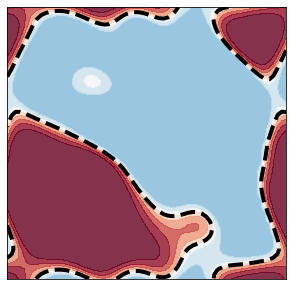

In [28]:

from numpy import arange, meshgrid, hstack
plt.figure()
fig= plt.figure(figsize=(5,5))
cm = plt.cm.RdBu_r
# plot decision regions
cnt = plt.contourf(xx, yy,zz, levels=np.arange(0, 1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy,zz, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(4.0,))



plt.title(label=LABELplot,
          fontsize=12,
          color="Black")
plt.xlabel('')
plt.ylabel('')

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()